In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stock_module as sm
import random
import os
import datetime
import time
import openpyxl
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
from scipy.signal import lfilter

In [2]:
def ma_columns(frame_column, list_ma):
    MAs = [] 
    for ma in list_ma:
        MA = pd.DataFrame(sm.short_moving_average(frame_column, ma)["StockValue"]).rename(columns={"StockValue": f"MA_{ma}"})
        MAs.append(MA)
        
    frame = MAs[0].join(MAs[1])
    for i in range(len(MAs)-2):
        frame = frame.join(MAs[i+2])
    
    frame = frame.dropna()
    
    return frame

In [3]:
def convert_date(date):
    return datetime.datetime.strptime(date, "%d-%m-%Y")

In [4]:
def convert_str_from_date(date: str):
    return datetime.datetime.strftime(date, "%d-%m-%Y")

In [5]:
def increment_date(date:str, increment_day:int):
    date = convert_date(date)
    date = date + datetime.timedelta(days=increment_day)
    date = convert_str_from_date(date)
    
    return date

In [6]:
def value_drawdowns(frame, start_date, end_date):
    """
    Purpose is to create a dataframe showing drawdowns for values
    """
    
    values = frame["StockValue"]
    previous_peak = values.cummax()
    drawdowns = (values - previous_peak) / previous_peak
    
    frame = pd.DataFrame({
            "Wealth": values,
            "Peaks" : previous_peak, 
            "Drawdown": drawdowns    
            })

    return frame

In [7]:
def momentum(frame, frame_column:str, momentum_day, mode="diff"):
    """
    Belirtilen frame ve belirtilen sütunu için, belirtilen gün kadar önceki değerleri ile kıyaslar
    """
    if mode == "diff":
        frame[f"{frame_column}_diff_{momentum_day}"] = frame[f"{frame_column}"].diff(momentum_day)
    elif mode == "pct_change":
        frame[f"{frame_column}_pct_change_{momentum_day}"] = frame[f"{frame_column}"].pct_change(momentum_day)
        
    frame = frame.dropna()
       
    return frame

In [42]:
def frame(stock_name, ma_list, start_date, end_date):
    frame = pd.read_pickle(stock_name)
    
    frame = frame[(frame.HGDG_TARIH < end_date) & (frame.HGDG_TARIH > start_date)]
    date = frame[["HGDG_TARIH"]]
    
    movingAverages = ma_columns(frame[["StockValue"]], ma_list)
    
    frame = frame.join(movingAverages)
    
    frame["StockValue_30_lag"] = frame["StockValue"].pct_change(30)
    
    frame = frame.dropna()
    
    return frame

In [43]:
stock_name = "TKFEN"
ma_list=[7,14,50,100,200]
noise_first_par = 51
noise_second_par = 2

start_date = "01-01-2011"
end_date = "01-02-2020"

In [44]:
frame = frame(stock_name, ma_list, start_date, end_date)

In [45]:
frame

,HGDG_HS_KODU,HGDG_TARIH,StockValue,HGDG_AOF,HGDG_MIN,HGDG_MAX,HGDG_HACIM,END_ENDEKS_KODU,END_TARIH,END_SEANS,...,HG_HACIM,DOLAR_BAZLI_MIN,DOLAR_BAZLI_MAX,DOLAR_BAZLI_AOF,MA_7,MA_14,MA_50,MA_100,MA_200,StockValue_30_lag
974,TKFEN,2011-10-13,4.2918,4.308356,4.247406,4.365799,4511493.0,01,1318453200000,2,...,2818641.0,2.3188,2.3835,2.3521,4.272771,4.204057,3.866744,4.058785,4.320085,0.106876
975,TKFEN,2011-10-14,4.3658,4.340072,4.277004,4.380599,10109477.0,01,1318539600000,2,...,8911547.0,2.3280,2.3844,2.3623,4.306600,4.238943,3.869704,4.059244,4.317858,0.121679
976,TKFEN,2011-10-17,4.3806,4.414365,4.365799,4.469395,6821148.0,01,1318798800000,2,...,3258470.0,2.3674,2.4236,2.3938,4.331971,4.262200,3.873256,4.059418,4.314983,0.174613
977,TKFEN,2011-10-18,4.3510,4.387999,4.321402,4.454596,9469873.0,01,1318885200000,2,...,2293452.0,2.3149,2.3862,2.3505,4.342543,4.271714,3.878584,4.059440,4.311021,0.157489
978,TKFEN,2011-10-19,4.2622,4.321977,4.247406,4.410198,2676088.0,01,1318971600000,2,...,2031779.0,2.2949,2.3829,2.3352,4.329857,4.269600,3.889240,4.059144,4.306254,0.129419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3034,TKFEN,2019-12-25,18.4176,18.358105,18.235193,18.446447,149099897.0,01,1577221200000,2,...,149099897.0,3.0699,3.1055,3.0906,17.831886,17.664529,17.434916,18.427048,21.064691,0.039562
3035,TKFEN,2019-12-26,18.2448,18.399395,18.158373,18.542473,128565337.0,01,1577307600000,2,...,128565337.0,3.0565,3.1212,3.0971,17.893614,17.718029,17.478320,18.378459,21.042470,0.057320
3036,TKFEN,2019-12-27,18.4368,18.382110,18.033540,18.638498,340523722.0,01,1577394000000,2,...,340523722.0,3.0320,3.1337,3.0906,18.034900,17.782500,17.528828,18.338704,21.017479,0.050901
3037,TKFEN,2019-12-30,18.8690,18.785418,18.523270,18.984190,254936284.0,01,1577653200000,2,...,254936284.0,3.1127,3.1901,3.1567,18.236557,17.891557,17.581450,18.313258,20.992829,0.060443


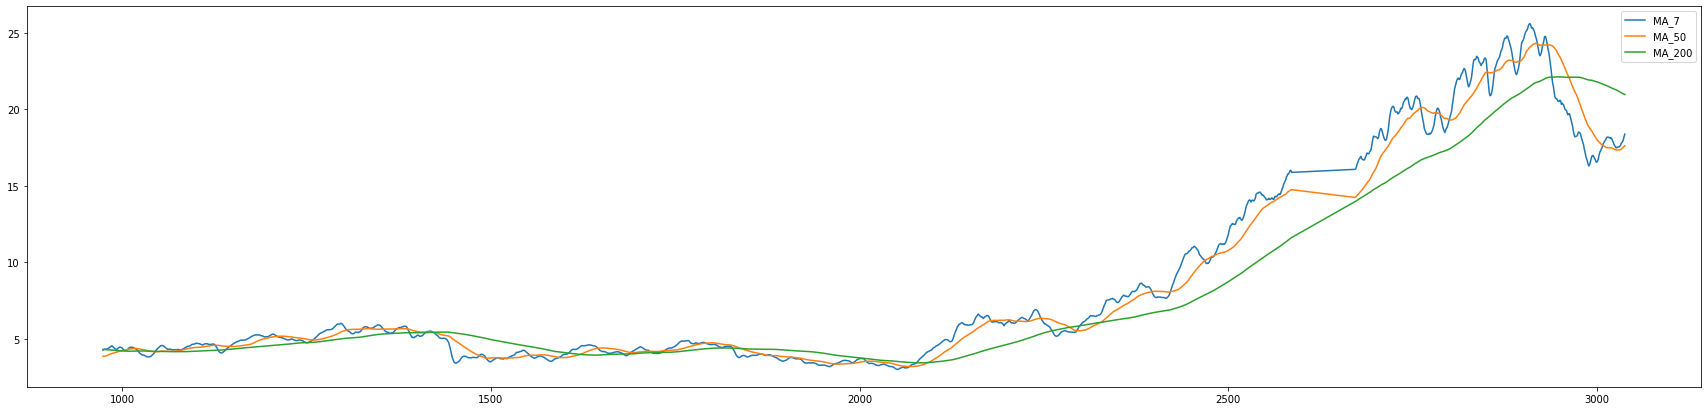

In [46]:
frame[["MA_7","MA_50","MA_200"]].plot(figsize=(30,7))

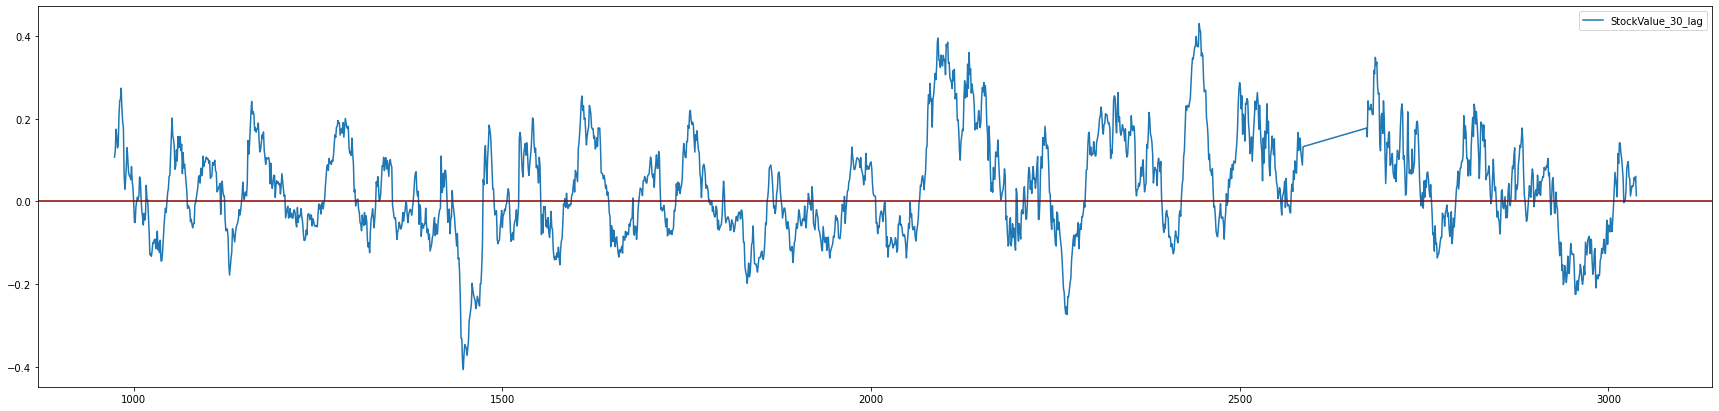

In [47]:
frame[["StockValue_30_lag"]].plot(figsize=(30,7))
plt.axhline(0, color="darkred")

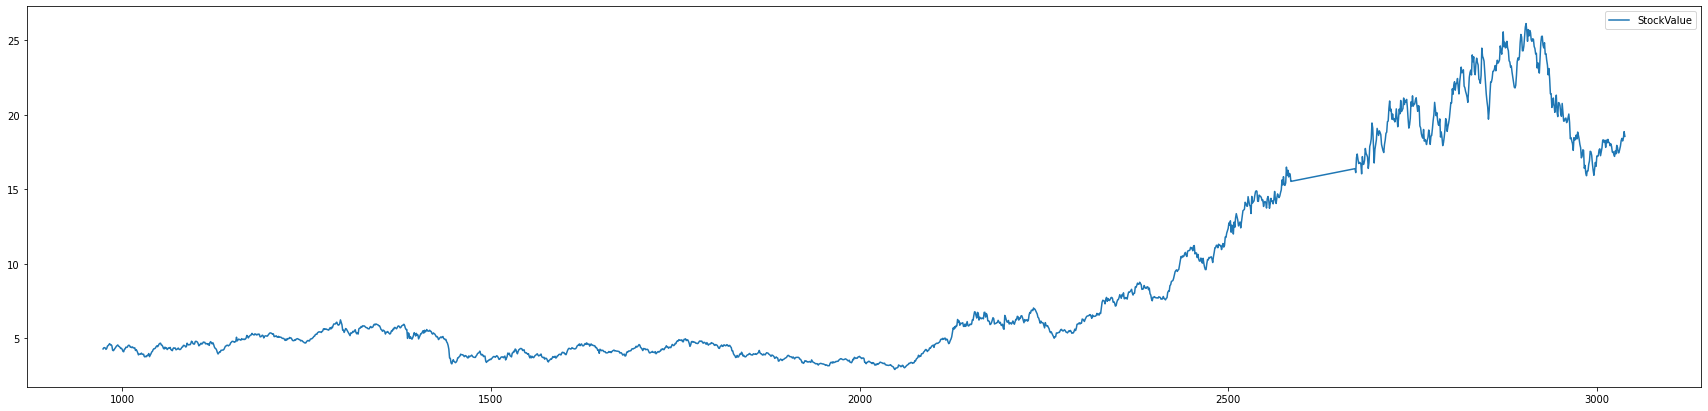

In [48]:
frame[["StockValue"]].plot(figsize=(30,7))